# Постановка задачи

Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Выгрузка датасета

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

In [2]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
        df = pd.read_csv('/Users/aleksandrfilippov/Documents/ipynb/games.csv')

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


###  Подготовка данных

In [4]:
#Для начала приведем названия столбцов к нижнему регистру, для упрощения дальнейшей работы
df.columns = df.columns.str.lower()

In [5]:
df = df.drop_duplicates(subset=['name', 'platform', 'year_of_release'], keep='first').reset_index(drop=True)

In [6]:
# Изменим тип столбца user_score на float, для дальнейших вычислений
# Так как в этом столбце есть значение tbd(to be determined), можно заменить его на NaN
df['user_score'] = (df['user_score']
                    .replace('tbd', float('nan'))
                    .astype(float))

In [7]:
# Заполним пропуски где это возможно
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           9948 non-null   object 
dtypes: float64(7), object(4)
memory usage: 1.4+ MB


In [8]:
# check
# пропущенные значения бары

def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (19,6), rot = -5, legend = False, fontsize = 16)
            .set_title('Пример' + "\n", fontsize = 22, color = 'SteelBlue')    
        );    
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

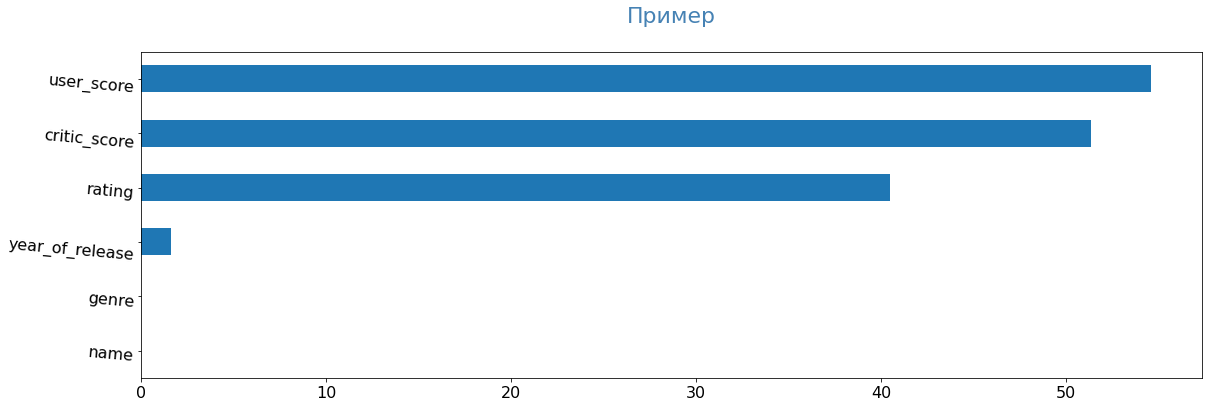

In [9]:
pass_value_barh(df)

In [10]:
pd.DataFrame(df
              .isna()
              .mean()
              .sort_values(ascending=False)
              *100
            ).style.background_gradient('coolwarm')

,0
user_score,54.592234
critic_score,51.319332
rating,40.477473
year_of_release,1.609526
name,0.005983
genre,0.005983
platform,0.000000
na_sales,0.000000
eu_sales,0.000000
jp_sales,0.000000


- name / genre - Заменим значения на 'UNKNOWN', чтобы сохранить данные для вычислений и избавиться от пропусков
- year_of_release - заменять их смысла нет, так как неизвестен год выпуска
- critic_score / user_score / rating - определить какую либо закономерность с другими параметрами не удалось(продажи, год выпуска, платформа), поэтому оставляем значения без изменений

In [11]:
df['name'] = df['name'].dropna()
df['genre'] = df['genre'].dropna()

In [12]:
# Добавим новый столбец с суммарными продажами
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

In [13]:
# check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16713 entries, 0 to 16712
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       7589 non-null   float64
 10  rating           9948 non-null   object 
 11  total_sales      16713 non-null  float64
dtypes: float64(8), object(4)
memory usage: 1.5+ MB


In [14]:
df[df['rating'].isna()].head(20)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN,30.26
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN,28.31
10,Nintendogs,DS,2005.0,Simulation,9.05,10.95,1.93,2.74,NaN,NaN,NaN,24.67
12,Pokemon Gold/Pokemon Silver,GB,1999.0,Role-Playing,9.00,6.18,7.20,0.71,NaN,NaN,NaN,23.09
18,Super Mario World,SNES,1990.0,Platform,12.78,3.75,3.54,0.55,NaN,NaN,NaN,20.62
20,Pokemon Diamond/Pokemon Pearl,DS,2006.0,Role-Playing,6.38,4.46,6.04,1.36,NaN,NaN,NaN,18.24
21,Super Mario Land,GB,1989.0,Platform,10.83,2.71,4.18,0.42,NaN,NaN,NaN,18.14
22,Super Mario Bros. 3,NES,1988.0,Platform,9.54,3.44,3.84,0.46,NaN,NaN,NaN,17.28


#### Вывод по подготовке данных:
- Удалены неполные дубликаты
- Тип столбца user_score был изменен на float
- Визуализирована информация о датасете

### Исследовательский анализ данных

#### Количество выпущенных игр по годам

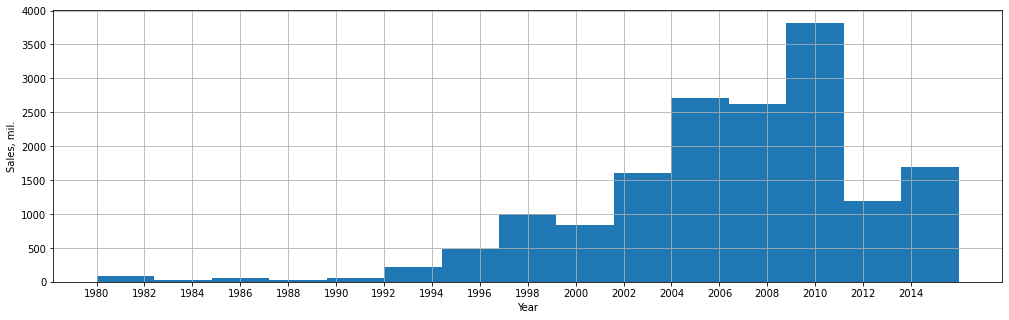

In [15]:
df['year_of_release'].plot(kind = 'hist', bins = 15, figsize = (17,5)).grid()
plt.xlabel('Year')
plt.ylabel('Sales, mil.')
plt.xticks(np.arange(1980, 2016, 2))
plt.show()

#### Продажи по платформам

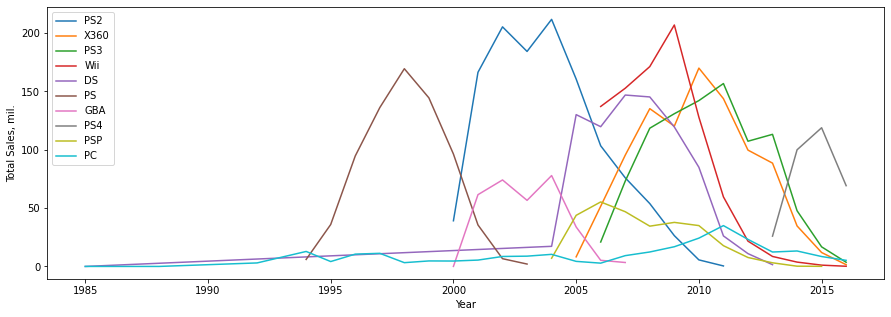

In [16]:
# Построим график продаж топ 10 платформ по годам 
platform_sales = df.groupby('platform')['total_sales'].sum()
platform_top_sales = platform_sales.nlargest(10)

for platform in platform_top_sales.index:
    platform_data = df[df['platform'] == platform]
    platform_data.groupby('year_of_release')['total_sales'].sum().plot(label=platform,figsize = (15,5))

plt.xlabel('Year')
plt.ylabel('Total Sales, mil.')
plt.legend()
plt.show()


На графике виден очевидный выброс для консоли Nintendo DS, ведь консоль вышла только в 2004 году, заменим данные и взглянем на график еще раз

In [17]:
df[df['platform']== 'DS'].sort_values('year_of_release')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15956,Strongest Tokyo University Shogi DS,DS,1985.0,Action,0.00,0.00,0.02,0.0,NaN,NaN,NaN,0.02
13463,Cocoto Kart Racer,DS,2004.0,Racing,0.04,0.00,0.00,0.0,NaN,NaN,E,0.04
11517,Kenshuui Tendo Dokuta,DS,2004.0,Simulation,0.00,0.00,0.08,0.0,NaN,NaN,NaN,0.08
4421,The Urbz: Sims in the City (all regions sales),DS,2004.0,Simulation,0.40,0.01,0.02,0.0,NaN,NaN,NaN,0.43
7902,Daigasso! Band Brothers,DS,2004.0,Misc,0.00,0.00,0.19,0.0,NaN,NaN,NaN,0.19
...,...,...,...,...,...,...,...,...,...,...,...,...
15794,Shonen Jump's Yu-Gi-Oh! GX Card Almanac,DS,NaN,Misc,0.00,0.00,0.02,0.0,NaN,NaN,NaN,0.02
15952,PDC World Championship Darts 2008,DS,NaN,Sports,0.01,0.00,0.00,0.0,NaN,NaN,NaN,0.01
15997,Jet Impulse,DS,NaN,Simulation,0.00,0.00,0.02,0.0,NaN,NaN,NaN,0.02
16016,Dream Dancer,DS,NaN,Misc,0.01,0.00,0.00,0.0,NaN,NaN,E,0.01


In [18]:
df.loc[15957,'year_of_release'] = 2010

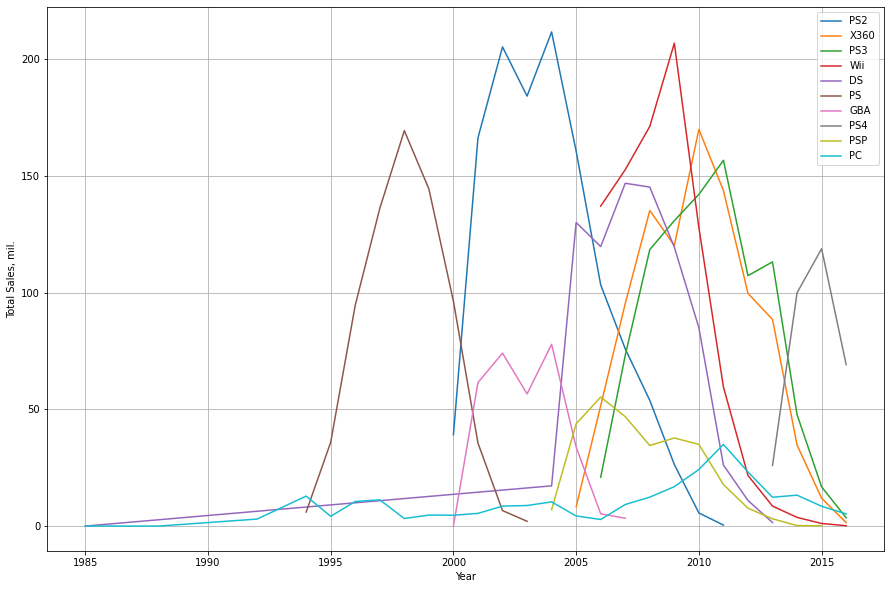

In [19]:
# Построим график продаж топ 10 платформ по годам 
platform_sales = df.groupby('platform')['total_sales'].sum()
platform_top_sales = platform_sales.nlargest(10)

for platform in platform_top_sales.index:
    platform_data = df[df['platform'] == platform]
    platform_data.groupby('year_of_release')['total_sales'].sum().plot(label=platform,figsize = (15,10)).grid()

plt.xlabel('Year')
plt.ylabel('Total Sales, mil.')
plt.legend()
plt.show()

#### Выбор актуального периода для прогноза на 2017 год

Цикл жизни платформ приблизительно 10 лет, хотя бы одна платформа появляется в пятилетний период. Визуально актуальный период для прогноза на 2017 год является период с 2014 по 2016 года.

In [20]:
relevant_df = df[df['year_of_release'] > 2013]

#### Анализ лидирующих платформ

In [21]:
pd.DataFrame(relevant_df
              .groupby('platform')['total_sales']
              .sum()
              .sort_values(ascending=False)).style.background_gradient('coolwarm')

,total_sales
platform,
PS4,288.150000
XOne,140.360000
3DS,86.680000
PS3,68.180000
X360,48.220000
WiiU,42.980000
PC,27.050000
PSV,22.400000
Wii,5.070000


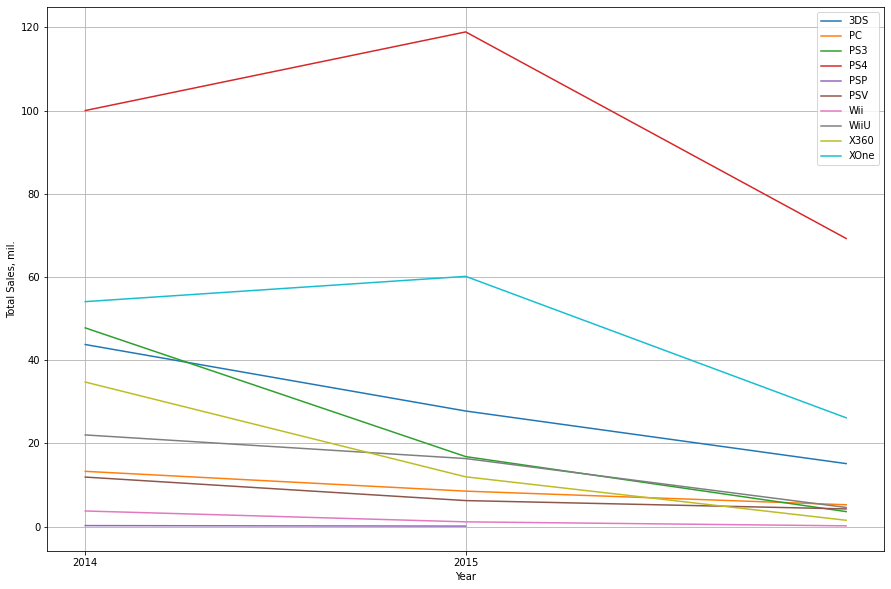

In [22]:
relevant_platform_sales = relevant_df.groupby('platform')['total_sales'].sum()


for platform in relevant_platform_sales.index:
    platform_data = relevant_df[relevant_df['platform'] == platform]
    platform_data.groupby('year_of_release')['total_sales'].sum().plot(label=platform,figsize = (15,10)).grid()

plt.xlabel('Year')
plt.ylabel('Total Sales, mil.')
plt.xticks(np.arange(2014, 2016, 1))
plt.legend()
plt.show()

В целом вся игорная индустрия находится в данный момент на спаде. Самые прибыльные за актуальный период платформы это:
- PS 4
- XOne
- 3DS

Визуально картина не меняется однако стоит учитывать что PC уже на рынке более 30 лет и показатели продаж хоть и не являются максимальными, зато из года в год показывают стабильный результат, поэтому **потенциально прибильные платформы по имеющимся данным это:**
- PS 4
- XOne
- 3DS
- PC

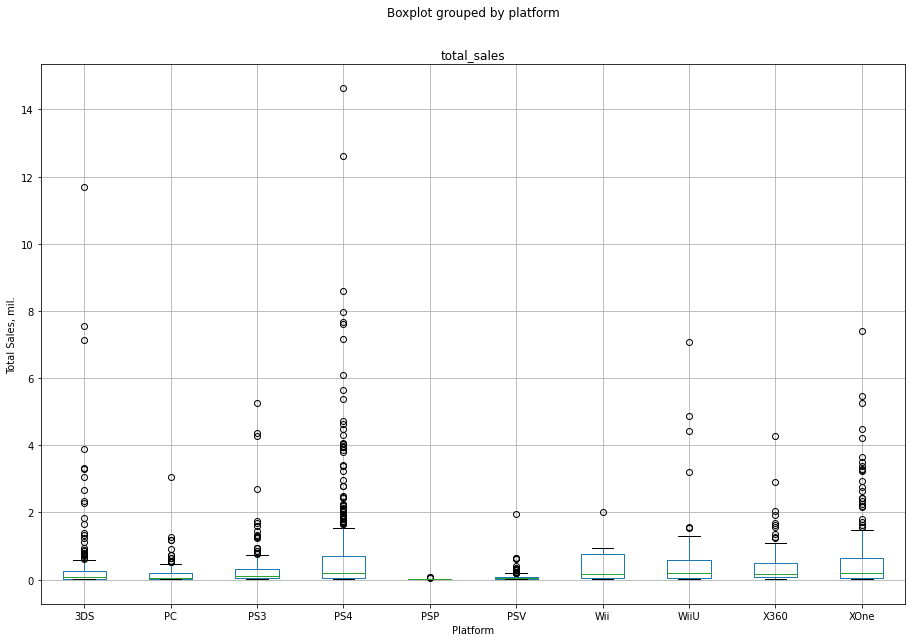

In [23]:
relevant_df.boxplot(column=['total_sales'], by='platform', figsize=(15, 10))
plt.xlabel('Platform')
plt.ylabel('Total Sales, mil.')
plt.show()

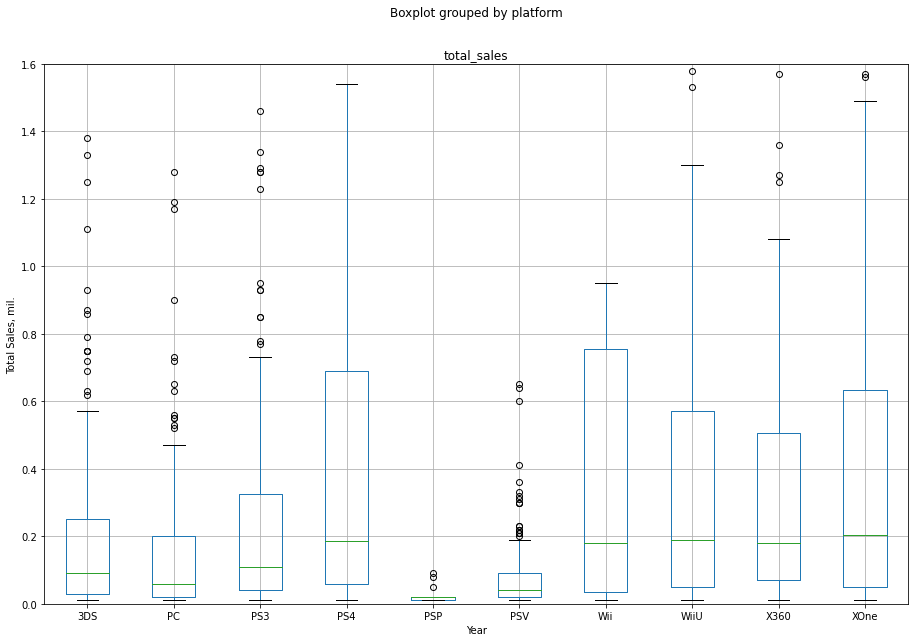

In [24]:
relevant_df.boxplot(column=['total_sales'], by='platform', figsize=(15, 10))
plt.xlabel('Year')
plt.ylabel('Total Sales, mil.')
plt.ylim(0, 1.6)
plt.show()

In [25]:
relevant_df.groupby('platform')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,212.0,0.408868,1.188368,0.01,0.0300,0.090,0.2500,11.68
PC,151.0,0.179139,0.329359,0.01,0.0200,0.060,0.2000,3.05
PS3,219.0,0.311324,0.633059,0.01,0.0400,0.110,0.3250,5.27
PS4,376.0,0.766356,1.614969,0.01,0.0575,0.185,0.6900,14.63
PSP,13.0,0.027692,0.027735,0.01,0.0100,0.020,0.0200,0.09
PSV,295.0,0.075932,0.141591,0.01,0.0200,0.040,0.0900,1.96
Wii,11.0,0.460909,0.625451,0.01,0.0350,0.180,0.7550,2.01
WiiU,73.0,0.588767,1.161467,0.01,0.0500,0.190,0.5700,7.09
X360,111.0,0.434414,0.628967,0.01,0.0700,0.180,0.5050,4.28


По этим данным можно сделать следующие выводы по платформам:

**Топ 3 по максимальным продажам игры:**
- PS4
- 3DS
- XOne

**Топ 3 по количеству игр:**
- PS4
- PSV
- XOne

**Топ 3 по средним продажам одной игры:**
- PS4
- XOne
- WiiU

**Топ 3 "стабильных" платформ(наименьшее стандартное отклонение):**
- PSP
- PSV
- PC

Стоит отметить, что минимальное значение проданных копий игр у всех платформ одинаковое(0.01млн), а медианное значение проданных копий не превышает 0.205млн копий 

#### Влияние отзывов на продажи

Для того, чтобы оценить влияние оценок пользователей и критиков на продажи возьмем платформу PS4

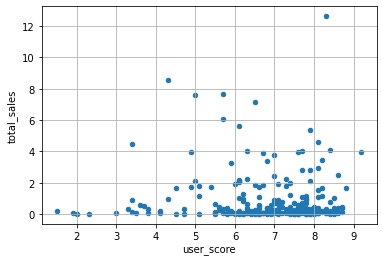

-0.04

In [26]:
ps4 = relevant_df[relevant_df['platform'] == 'PS4']
ps4.plot(x='user_score',
         y='total_sales',
         kind='scatter',
         grid=True)
plt.show()
round(ps4['user_score'].corr(ps4['total_sales']), 2)

Удостоверимся, что влияние действительно околонулевое на примере XOne

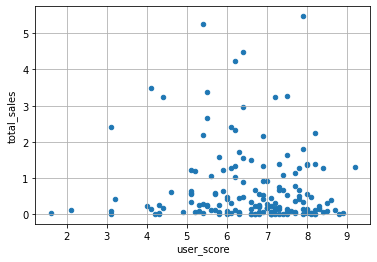

-0.07

In [27]:
xone = relevant_df[relevant_df['platform'] == 'XOne']
xone.plot(x='user_score',
          y='total_sales',
          kind='scatter',
          grid=True)
plt.show()
round(xone['user_score'].corr(xone['total_sales']) , 2)

Пользовательский рейтинг практически никак не влияет на продажи игр.

Рассмотрим аналогичным образом влияние критиков

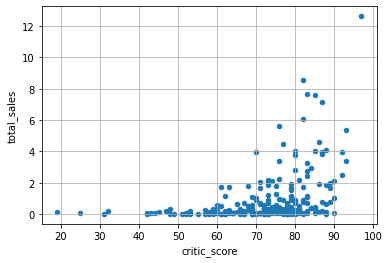

0.4

In [28]:
ps4 = relevant_df[relevant_df['platform'] == 'PS4']
ps4.plot(x='critic_score',
         y='total_sales',
         kind='scatter',
         grid=True)
plt.show()
round(ps4['critic_score'].corr(ps4['total_sales']), 2)

У PS4 слабое влияние присутствует

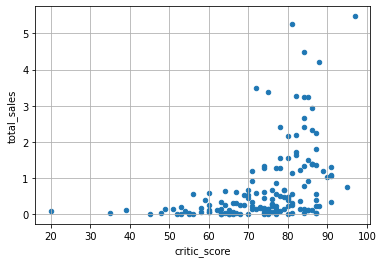

0.43

In [29]:
xone = relevant_df[relevant_df['platform'] == 'XOne']
xone.plot(x='critic_score',
          y='total_sales',
          kind='scatter',
          grid=True)
plt.show()
round(xone['critic_score'].corr(xone['total_sales']), 2)

Можно сделать вывод, что зависимость между оценками критиков и продажами слабая, а продажи и пользовательские оценки никак не зависят

#### Распределение по жанрам

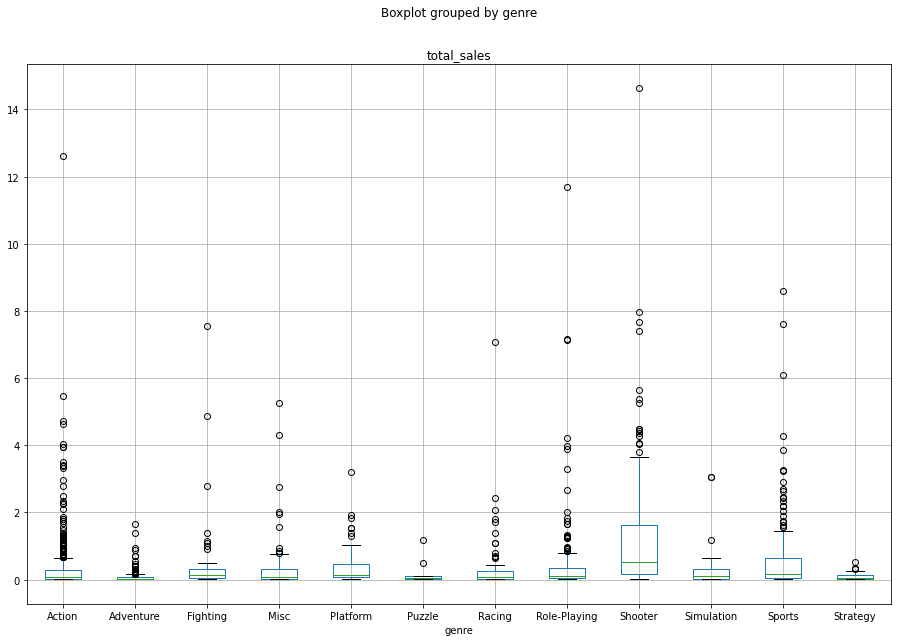

In [30]:
relevant_df.boxplot(column=['total_sales'], by='genre', figsize=(15, 10))
plt.show()

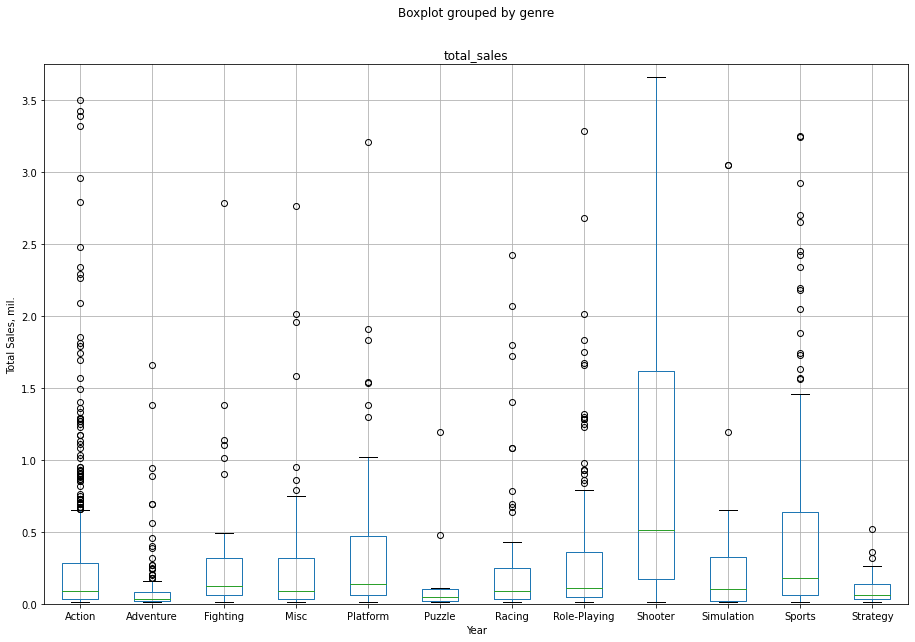

In [31]:
relevant_df.boxplot(column=['total_sales'], by='genre', figsize=(15, 10))
plt.xlabel('Year')
plt.ylabel('Total Sales, mil.')
plt.ylim(0, 3.75)
plt.show()

In [32]:
relevant_df.groupby('genre')['total_sales'].describe()

,count,mean,std,min,25%,50%,75%,max
genre,,,,,,,,
Action,619.0,0.322068,0.798181,0.01,0.0300,0.090,0.2800,12.62
Adventure,185.0,0.094865,0.203147,0.01,0.0200,0.030,0.0800,1.66
Fighting,60.0,0.470333,1.188053,0.01,0.0600,0.125,0.3200,7.55
Misc,113.0,0.332301,0.736999,0.01,0.0300,0.090,0.3200,5.27
Platform,38.0,0.476053,0.722561,0.01,0.0625,0.140,0.4675,3.21
Puzzle,14.0,0.157857,0.320629,0.01,0.0200,0.045,0.1000,1.19
Racing,69.0,0.398841,0.963716,0.01,0.0300,0.090,0.2500,7.09
Role-Playing,221.0,0.459005,1.177284,0.01,0.0500,0.110,0.3600,11.68
Shooter,128.0,1.335469,2.050567,0.01,0.1725,0.515,1.6175,14.63


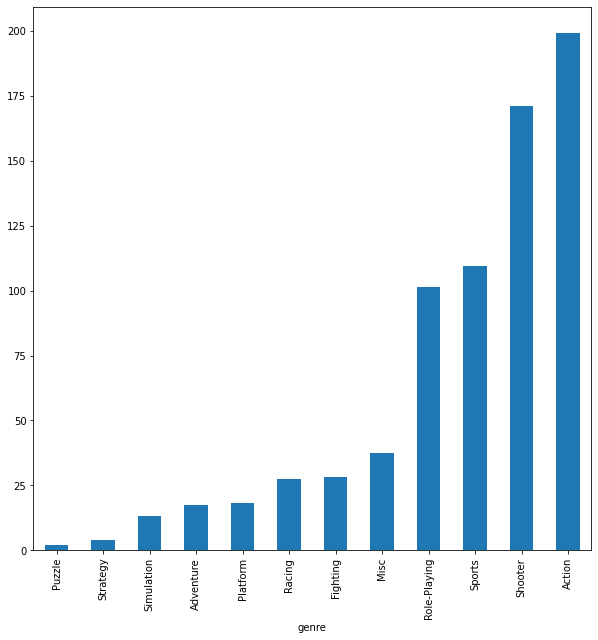

In [33]:
(relevant_df
 .groupby('genre')['total_sales']
 .sum()
 .sort_values()
 .plot(kind = 'bar', figsize = (10,10)))

plt.show()

Самые прибыльные игры жанра Action и Shooter, наименьшая сумма продаж у игр жанра Puzzle и Strategy.

Выводы про прибыльные жанры:
- Action берет количеством, а не качеством (в 5 раз больше игр, чем жанр Shooter, однако среднее значения жанра Shooter по продажам в 4 раза больше чем у Action)
- Игры жанра Shooter в свою очередь очень нестабильны в продажах(самое высокое стандартное отклонение в 2млн копий)


### Портрет пользователя по регионам

In [34]:
na_reg = relevant_df[relevant_df['na_sales'] > 0][['platform', 'na_sales', 'genre', 'rating', 'year_of_release']]
eu_reg = relevant_df[relevant_df['eu_sales'] > 0][['platform', 'eu_sales', 'genre', 'rating', 'year_of_release']]
jp_reg = relevant_df[relevant_df['jp_sales'] > 0][['platform', 'jp_sales', 'genre', 'rating', 'year_of_release']]

#### Самые популярные платформы (топ-5)

In [35]:
#Создадим переменные, чтобы отоброжались топ-5 по платформам
#Для NA

na_top_platform = (na_reg
                  .groupby('platform')['na_sales']
                  .sum()
                  .nlargest(5))
na_top_platform['Others'] = na_reg.loc[~na_reg['platform'].isin(na_top_platform.index), 'na_sales'].sum()

#Для EU

eu_top_platform = (eu_reg
                  .groupby('platform')['eu_sales']
                  .sum()
                  .nlargest(5))
eu_top_platform['Others'] = eu_reg.loc[~eu_reg['platform'].isin(eu_top_platform.index), 'eu_sales'].sum()

#Для JP

jp_top_platform = (jp_reg
                  .groupby('platform')['jp_sales']
                  .sum()
                  .nlargest(5))
jp_top_platform['Others'] = jp_reg.loc[~jp_reg['platform'].isin(jp_top_platform.index), 'jp_sales'].sum()


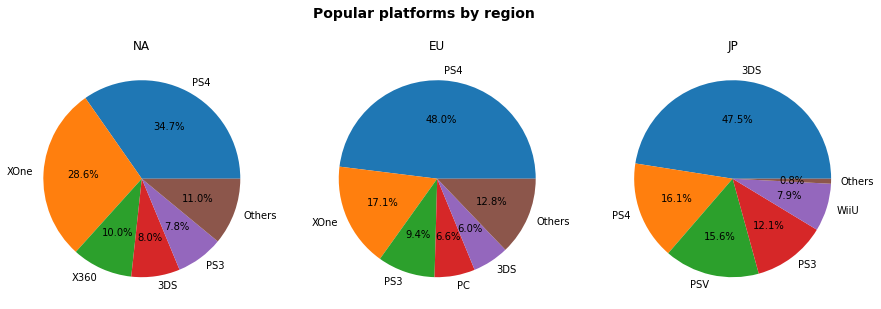

In [36]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,ncols=3, sharey=True, figsize=(15, 5))

ax0.pie(na_top_platform, labels=na_top_platform.index, autopct='%1.1f%%')
ax0.set_title('NA')

ax1.pie(eu_top_platform, labels=eu_top_platform.index, autopct='%1.1f%%')
ax1.set_title('EU')

ax2.pie(jp_top_platform, labels=jp_top_platform.index, autopct='%1.1f%%')
ax2.set_title('JP')

fig.suptitle('Popular platforms by region', fontsize=14, fontweight='bold');
plt.show()

Топ 5 популярных консолей в Северной Америке:
- PS4(34.7%)
- XOne(28.6%)
- X360(10%)
- 3DS(8%)
- PS3(7.8%)

Топ 5 популярных консолей в Европе:
- PS4(48%)
- XOne(17.1%)
- PS3(9.4%)
- PC(6.6%)
- 3DS(6%)

Топ 5 популярных консолей в Японии:
- 3DS(47.5%)
- PS4(16.1%)
- PSV(15.6%)
- PS3(12.1%)
- WiiU(7.9%)

####  Самые популярные жанры (топ-5)

In [37]:
#Создадим переменные, чтобы отоброжались топ-5 по жанрам
#Для NA
na_top_genre = (na_reg
                  .groupby('genre')['na_sales']
                  .sum()
                  .nlargest(5))
na_top_genre['Others'] = na_reg.loc[~na_reg['genre'].isin(na_top_genre.index), 'na_sales'].sum()

#Для EU
eu_top_genre = (eu_reg
                  .groupby('genre')['eu_sales']
                  .sum()
                  .nlargest(5))
eu_top_genre['Others'] = eu_reg.loc[~eu_reg['genre'].isin(eu_top_genre.index), 'eu_sales'].sum()

#Для JP
jp_top_genre = (jp_reg
                  .groupby('genre')['jp_sales']
                  .sum()
                  .nlargest(5))
jp_top_genre['Others'] = jp_reg.loc[~jp_reg['genre'].isin(jp_top_genre.index), 'jp_sales'].sum()


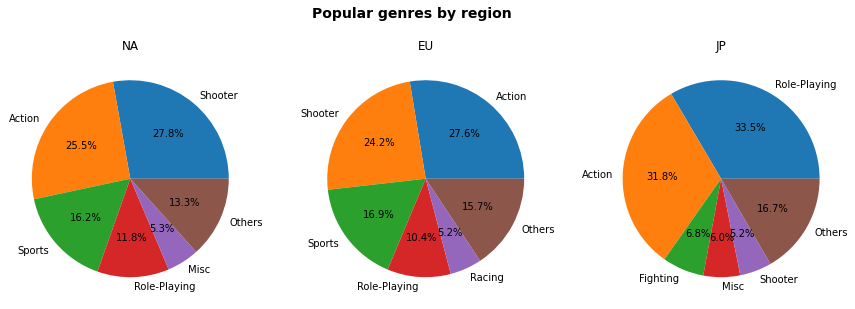

In [38]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,ncols=3, sharey=True, figsize=(15, 5))

ax0.pie(na_top_genre, labels=na_top_genre.index, autopct='%1.1f%%')
ax0.set_title('NA')

ax1.pie(eu_top_genre, labels=eu_top_genre.index, autopct='%1.1f%%')
ax1.set_title('EU')

ax2.pie(jp_top_genre, labels=jp_top_genre.index, autopct='%1.1f%%')
ax2.set_title('JP')

fig.suptitle('Popular genres by region', fontsize=14, fontweight='bold');
plt.show()

Топ 5 жанров игр в Северной Америке:
- Shooter(27.8%)
- Action(25.5%)
- Sports(16.2%)
- Role-Playing(11.8%)
- Misc(5.3%)

Топ 5 жанров игр в Европе:
- Action(27.6%)
- Shooter(24.2%)
- Sports(16.9%)
- Role-Playing(10.4%)
- Racing(5.2%)

Топ 5 жанров игр в Японии:
- Role-Playing(33.5%)
- Action(31.8%)
- Fighting(6.8%)
- Misc(6.0%)
- Shooter(5.2%)

#### Влияет ли рейтинг ESRB на продажи?

Для того, чтобы ответить на этот вопрос, можно привести к целочисленному варианту и присвоить значениям рейтинга оценку от 1 до 4, где 1 это самая широкая аудитория, а 4 это игры 18+
Таким образом преобразование будет выглядеть таким образом:
- E - 1
- E10+ - 2
- T - 3
- M - 4

По логике вещей, можно предположить, что чем обширнее "доступная" аудитория, тем больше продаж должно быть, то есть мы должны наблюдать угасающий тренд от 'E' до 'M'

In [39]:
na_reg['rating'].unique()

array([nan, 'M', 'E', 'T', 'E10+'], dtype=object)

##### Северная Америка

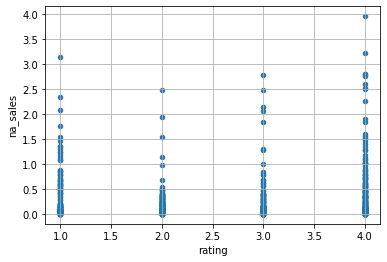

0.0741318381146555

In [40]:
na_reg['rating'] = na_reg['rating'].replace({'E' : 1,
                                             'E10+' : 2,
                                             'T' : 3,
                                             'M' : 4,
                                             'nan': np.nan
}).astype(float)


na_reg.plot(x='rating',
          y='na_sales',
          kind='scatter',
          grid=True)
plt.show()
na_reg['rating'].corr(na_reg['na_sales'])

Если рассматривать регион в целом, то можно сделать вывод, что рейтинг ESRB практически никак не влияет на продажи.


##### Европа

По аналогии с предыдущим пунктом приведем к типу float и посчитаем корреляцию

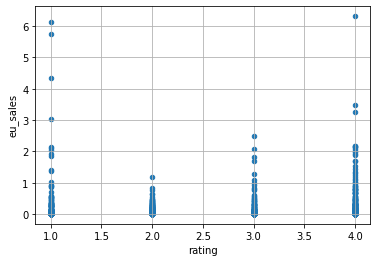

0.06100793451644468

In [41]:
eu_reg['rating'] = eu_reg['rating'].replace({'E' : 1,
                                             'E10+' : 2,
                                             'T' : 3,
                                             'M' : 4,
                                             'nan': np.nan
}).astype(float)


eu_reg.plot(x='rating',
           y='eu_sales',
           kind='scatter',
           grid=True)
plt.show()
eu_reg['rating'].corr(eu_reg['eu_sales'])

Если рассматривать регион в целом, то можно сделать вывод, что рейтинг ESRB практически никак не влияет на продажи.

##### Япония

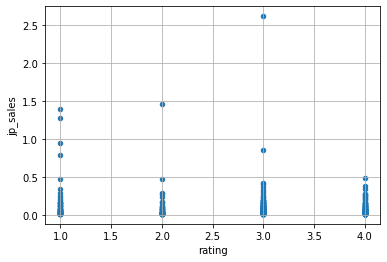

-0.1266628605476682

In [42]:
jp_reg['rating'] = jp_reg['rating'].replace({'E' : 1,
                                             'E10+' : 2,
                                             'T' : 3,
                                             'M' : 4,
                                             'nan': np.nan
}).astype(float)


jp_reg.plot(x='rating',
           y='jp_sales',
           kind='scatter',
           grid=True)
plt.show()
jp_reg['rating'].corr(jp_reg['jp_sales'])

Прослеживается слабая отрицательная корреляция, значит чем выше рейтинг игр, тем вероятнее ее популярность

#### Портрет по регионам, сводка

##### Портрет среднестатистического пользователя NA
Предпочтительные платформы: PS4 или XOne

Предпочтительные жанры: Shooter или Action

Влияние рейтинга ESRB: Околонулевое


##### Портрет среднестатистического пользователя EU
Предпочтительные платформы: PS4 или XOne

Предпочтительные жанры: Shooter или Action

Влияние рейтинга ESRB: Околонулевое

##### Портрет среднестатистического пользователя JP
Предпочтительные платформы: 3DS или консоли семейства PlayStation(4,V,3)

Предпочтительные жанры: Role-Playing или Action

Влияние рейтинга ESRB: Слабое отрицательное

#### Общий вывод по главе
Как и ожидалось, общая картина для NA и EU не сильно отличается:
- Платформы схожи, за исключением процента рынка и наличия популярности PС в Европе и X360 в Северной Америке
- Лидирующие 4 жанра идентичны, за исключением Misc в Северной Америке и Racing в Европе
- ESRB никак не влияет на популярность игр

В Японии картина отличается больше всего:
- Предпочтение отдается "местным" консолям и больше пользователей предпочитают портативные консоли
- Любимые жанры RP и Action, Shooter один из наименее популярных жанров
- "Детские" игры не так сильно интересны аудитории, однако рейтинг

### Проверка гипотез

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

Для проверки данной гипотезы будем использовать тест на равенство средних значений выборок ind

Гипотеза будет звучать так:
- H0 - Средние пользовательские рейтинги на Xbox One и PC одинаковые
- H1 - Средние пользовательские рейтинги на Xbox One и PC различаются

In [43]:
xone_rating = relevant_df[relevant_df['platform'] == 'XOne']['user_score'].dropna()
pc_rating = relevant_df[relevant_df['platform'] == 'PC']['user_score'].dropna()

alpha = 0.05
t_stat, p_value = st.ttest_ind(xone_rating, pc_rating)

print('p-value:', round(p_value,3))
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Средние пользовательские рейтинги на Xbox One и PC различаются.")
else:
    print("Не получилось отвергнуть нулевую гипотезу: Средние пользовательские рейтинги на Xbox One и PC одинаковые.")

p-value: 0.105
Не получилось отвергнуть нулевую гипотезу: Средние пользовательские рейтинги на Xbox One и PC одинаковые.


#### Средние пользовательские рейтинги жанров Action  и Sports разные.

Для проверки данной гипотезы будем использовать тест на равенство средних значений выборок ind

Гипотеза будет звучать так:

- H0 - Средние пользовательские рейтинги на Action и Sports одинаковые
- H1 - Средние пользовательские рейтинги на Xbox One и PC разные

In [45]:
action_rating = relevant_df[relevant_df['genre'] == 'Action']['user_score'].dropna()
sports_rating = relevant_df[relevant_df['genre'] == 'Sports']['user_score'].dropna()

alpha = 0.05
t_stat, p_value = st.ttest_ind(action_rating, sports_rating)

print('p-value:', p_value)
if p_value < alpha:
    print("Отвергаем нулевую гипотезу: Средние пользовательские рейтинги на Action и Sports различаются.")
else:
    print("Не получилось отвергнуть нулевую гипотезу: Средние пользовательские рейтинги на Action и Sports одинаковые.")

p-value: 2.8711147985105864e-19
Отвергаем нулевую гипотезу: Средние пользовательские рейтинги на Action и Sports различаются.


### Общий вывод


В данной работе были проведены следующие задания:
-  В ходе предобработки данных, были изменены типы данных, удалены дубликаты
-  Исследованы значения в датафреймах, а именно:
    - было проанализированно количество игр в разные годы;
    - был определен характерный срок жизни платформы и появление новой(в среднем платформа "живет" 10 лет, а новую можно ожидать в 5 летний период);
    - был выбран актуальный период для предсказания на 2017 год (2014-2016);
        - Потенциально прибыльными платформами являются - PS4, XOne, 3DS;
        - Влияние критиков есть, но оно среднее, а пользовательские оценки никак на продажи не влияют
        - Самые прибыльные игры жанра Action и Shooter, наименьшая сумма продаж у игр жанра Puzzle и Strategy.
- Составлен портрет пользователя каждого региона


  **NA:**
    
    По платформам:
    - PS4(34.7%)
    - XOne(28.6%)
    - X360(10%)
    - 3DS(8%)
    - PS3(7.8%)
    
    По жанрам:
    - Shooter(27.8%)
    - Action(25.5%)
    - Sports(16.2%)
    - Role-Playing(11.8%)
    - Misc(5.3%)
    
    
   **EU:**
    
    По платформам:
    - PS4(48%)
    - XOne(17.1%)
    - PS3(9.4%)
    - PC(6.6%)
    - 3DS(6%)
    
    По жанрам:
    - Action(27.6%)
    - Shooter(24.2%)
    - Sports(16.9%)
    - Role-Playing(10.4%)
    - Racing(5.2%)
    
    
   **JP:**
    
    По платформам:
    - 3DS(47.5%)
    - PS4(16.1%)
    - PSV(15.6%)
    - PS3(12.1%)
    - WiiU(7.9%)
    
    По жанрам:
    - Role-Playing(33.5%)
    - Action(31.8%)
    - Fighting(6.8%)
    - Misc(6.0%)
    - Shooter(5.2%)
    
Только в Японии прослеживается слабая отрицательная зависимость от рейтинга ESRB

- Были проверены следующие гипотезы:
    - Средние пользовательские рейтинги платформ Xbox One и PC одинаковые (Средние пользовательские рейтинги на Xbox One и PC одинаковые);
    - Средние пользовательские рейтинги жанров Action и Sports разные (Средние пользовательские рейтинги на Action и Sports различаются)
    
        
**По данным можно сделать главный вывод, что на 2017 год стоит обратить большее внимание на игры жанров Action и Shooter (по причине большего влияния сектора Северной Америки и Европы по продажам), а так же на консоли PS4 и XOne, однако не стоит забывать и про другие жанры и консоли, чтобы охватить больший рынок**